## EXERCISE 3

Study the data in the file x_XGB_24.dat (N=2000 samples) with labels y_XGB_24.dat. The dataset should be split into N' training samples and N'' validation samples, with N' + N'' = N

| Name | Surname | ID Number |
|------|---------|---------------------|
| Lucrezia | Rossi | 2122164 |
| Lorenzo | Calandra Buonaura | 2107761 |
| Andrea | Turci | 2106724 |

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import accuracy_score
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier
# XGBoost 
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

mycmap = "winter"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13

XGBoost version: 2.0.3


In [4]:
np.random.seed(12345)

dname="./DATA/"
str0="_XGB_24.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print(f"N={N}, N_train={N_train}, L={L}")

N=4000, N_train=3000, L=4


[-31.608 -29.544   6.773   9.554] 0
[46.451 15.318 24.891 15.357] 1
[ 24.771  46.131 -49.161 -39.356] 1
[-20.13   15.641  30.981  37.218] 1
[46.465 22.369 14.248 21.745] 1


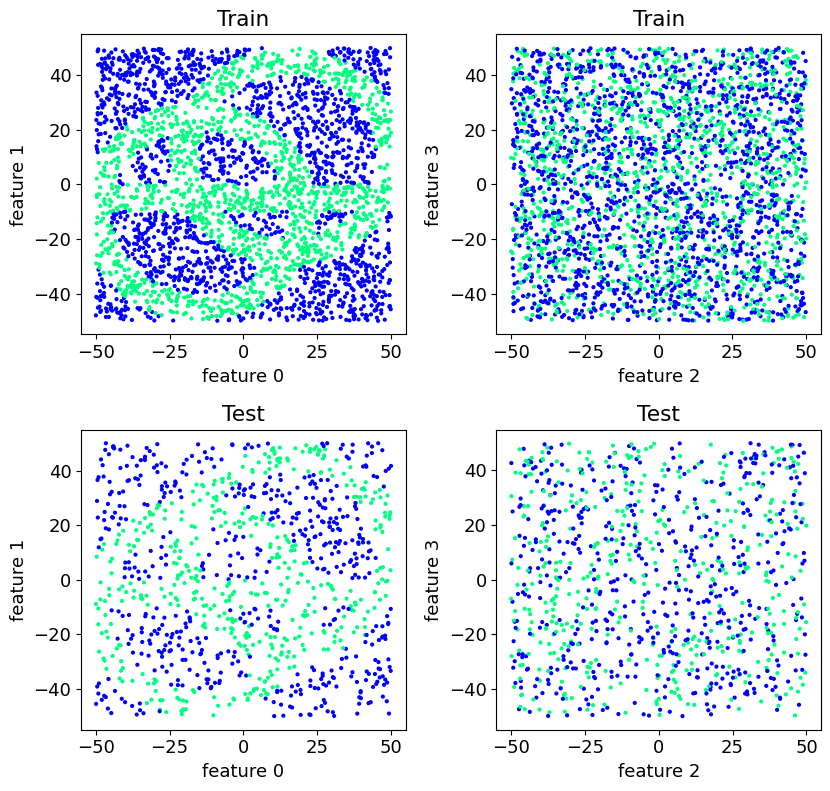

In [4]:
def scat(ax,x,y,i=0,j=1,s=4,title=""):
    ax.scatter(x[:,i],x[:,j],s=s,c=y)
    ax.set_xlabel(f"feature {i}")
    ax.set_ylabel(f"feature {j}")
    ax.set_title(title)

for n in range(5):
    print(x[n],y[n])

fig,AX = plt.subplots(2,2,figsize=(8.5,8.1))
scat(AX[0,0],x_train,y_train,title="Train")
scat(AX[0,1],x_train,y_train,i=2,j=3,title="Train")
scat(AX[1,0],x_test,y_test,title="Test")
scat(AX[1,1],x_test,y_test,i=2,j=3,title="Test")
fig.tight_layout()
plt.show()

### 1\. Model complexity, parameters’ and regularization
Try different parameters (λ, γ, n_estimators, ...). Which is the simplest yet effective XGBoost model that keeps a good validation accuracy? Is regularization useful for this analysis?

In [47]:
def classify(clf=GradientBoostingClassifier(),show=False):
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   n_estimators = 100 (default)
    #   max_depth = 3 (default?)
    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_test)
    
    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-clf.score(x_test, y_test)),clf.score(x_test, y_test)))
    S=50
    dx = 1
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,L))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:2] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)

    fig,AX = plt.subplots(1,2,figsize=(8.2,4))
    scat(AX[0],x_plot[:],y_plot,s=dx,title="predicted")
    scat(AX[1],x_train[:],y_train,title="training set")
    fig.tight_layout()
    plt.show()
    """
    if show:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(2,1,figsize=(12, 5))
        for i in range(min(2,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=400, pad_inches=0.02)   
        plt.show()
    """

errors: 5.20%   Accuracy=0.948


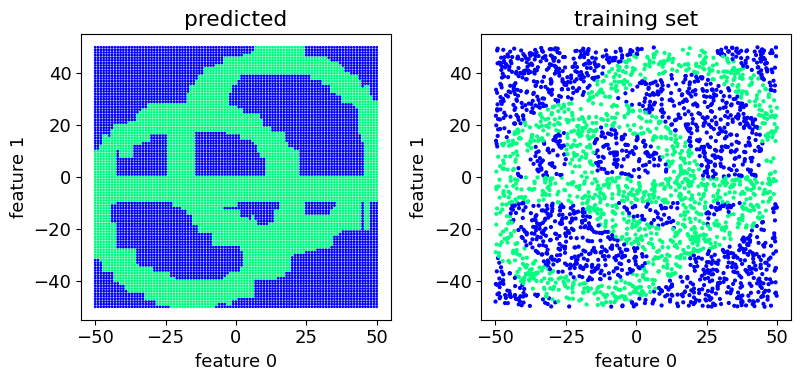

In [48]:
model = XGBClassifier(seed=1,
                      objective='binary:logistic') 
       # importance_type="gain" #weight, cover, ...
       # learning_rate=0.4,
       # reg_lambda=0.001, 
       # n_estimators=30)

classify(model, show=True)

In [7]:
from sklearn.model_selection import GridSearchCV


parameters = {
        'learning_rate': [0.001, 0.01, 0.05, 0.1],
        'n_estimators': [10, 50, 100, 150, 200],
        'max_depth': [3, 4, 5, 6, 7],
        'reg_lambda': [0.001, 0.01, 0.1, 0],
        'gamma': [0, 0.1, 0.2, 0.3]
    }

model = XGBClassifier(seed=1, objective='binary:logistic')
grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=3, scoring='accuracy')
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)

best_xgb_model =XGBClassifier(**best_params)
best_xgb_model.fit(x_train, y_train)
# Predictions
y_pred = best_xgb_model.predict(x_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Validation Accuracy:", accuracy)



Best Parameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'reg_lambda': 0.01}
Best Accuracy: 0.9273333333333333
Validation Accuracy: 0.951


In [8]:
xgb_model_no_reg = XGBClassifier()
xgb_model_no_reg.fit(x_train, y_train)
y_pred_no_reg = xgb_model_no_reg.predict(x_test)
accuracy_no_reg = accuracy_score(y_test, y_pred_no_reg)
print("Validation Accuracy without Regularization:", accuracy_no_reg)

Validation Accuracy without Regularization: 0.948


errors: 4.90%   Accuracy=0.951


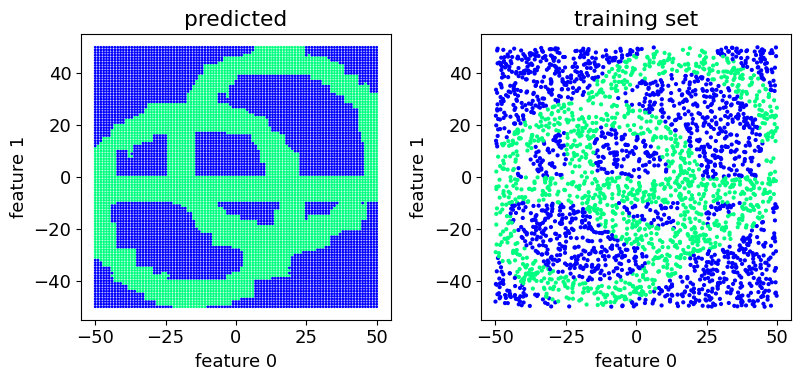

In [9]:
model = XGBClassifier(seed=1,
                      objective='binary:logistic',
       # importance_type="gain" #weight, cover, ...
       learning_rate=0.1,
       reg_lambda=0.01, 
       n_estimators=200, max_depth=7, gamma=0)

classify(model, show=True)

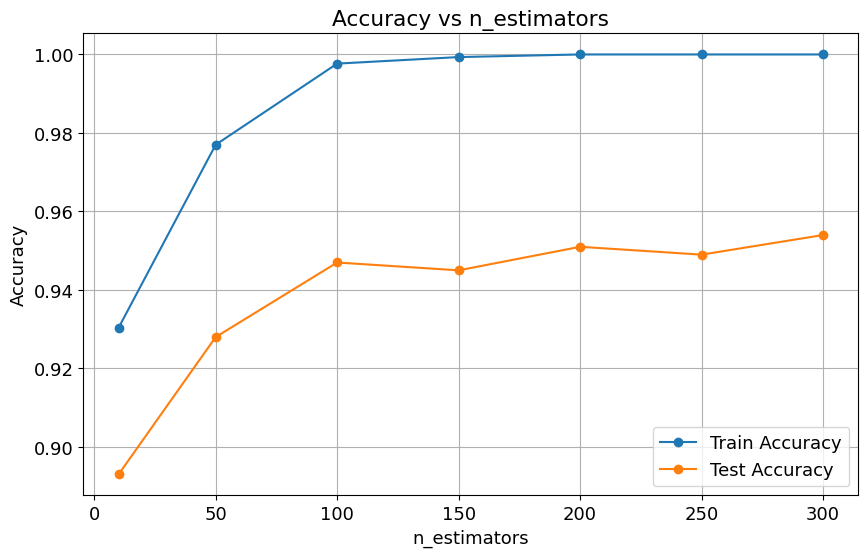

In [31]:
n_estimators_range = [10,50,100,150,200,250,300]
train_accuracies = []
test_accuracies = []

for n_estimators in n_estimators_range:
    model = XGBClassifier(n_estimators=n_estimators, seed=1,
                          objective='binary:logistic',
                          learning_rate=0.1,
                          reg_lambda=0.01,max_depth=7, gamma=0)

    model.fit(x_train, y_train)

    y_train_pred = model.predict(x_train)
    
    # Calculate train accuracy and store it
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)
    
    # Predictions on the test set
    y_test_pred = model.predict(x_test)
    
    # Calculate test accuracy and store it
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)


# Plot accuracy vs n_estimators
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(n_estimators_range, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Accuracy vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


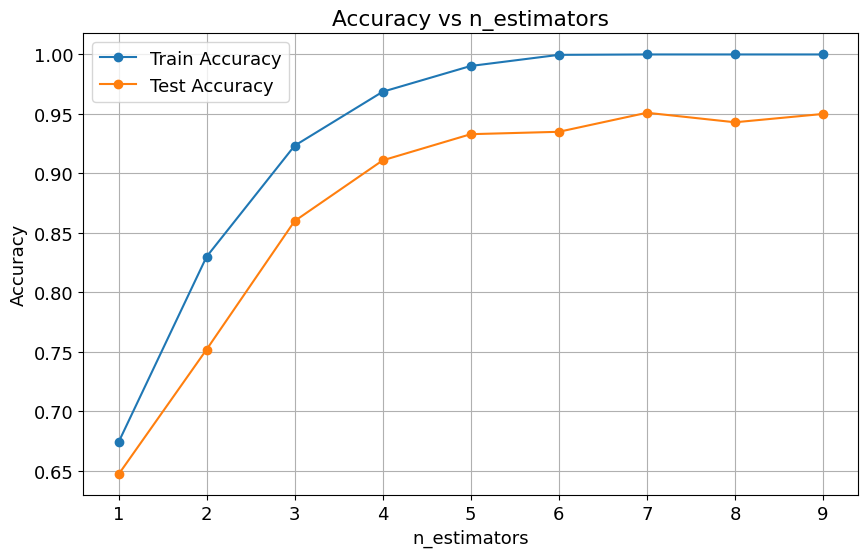

In [27]:

max_dephts_range = [1,2,3,4,5,6,7,8,9]
train_accuracies = []
test_accuracies = []

for max_dephts in max_dephts_range:
    model = XGBClassifier(n_estimators=200, seed=1,
                          objective='binary:logistic',
                          learning_rate=0.1,
                          reg_lambda=0.01, max_depth=max_dephts, gamma=0)

    model.fit(x_train, y_train)

    y_train_pred = model.predict(x_train)
    
    # Calculate train accuracy and store it
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)
    
    # Predictions on the test set
    y_test_pred = model.predict(x_test)
    
    # Calculate test accuracy and store it
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)


# Plot accuracy vs n_estimators
plt.figure(figsize=(10, 6))
plt.plot(max_dephts_range, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(max_dephts_range, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Accuracy vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

errors: 6.20%   Accuracy=0.938


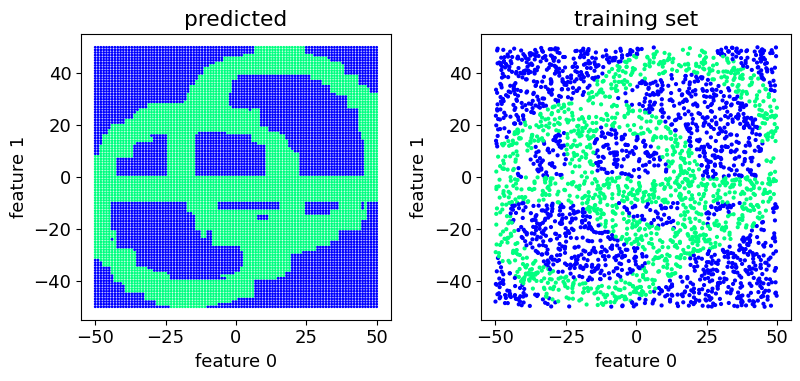

In [39]:
model = XGBClassifier(seed=1,
                      objective='binary:logistic',
       # importance_type="gain" #weight, cover, ...
       learning_rate=0.1,
       reg_lambda=0.1, reg_alpha=0.01,
       n_estimators=150, max_depth=6, gamma=0)

classify(model, show=True)

### 2\. Dimensionality reduction
Consider reduced data samples with L'\<L features. For example, feature 0,1, and 3 out of the L=4 features. Check if the exclusion of the least important feature(s) from training data leads to better accuracy.

In [53]:
from sklearn.metrics import accuracy_score

# Train the model using the original data with all features
original_model = XGBClassifier(seed=1, objective='binary:logistic',
       learning_rate=0.1,
       reg_lambda=0.1, reg_alpha=0.01,
       n_estimators=150, max_depth=6, gamma=0)
original_model.fit(x_train, y_train)

# Get feature importances
feature_importances = original_model.feature_importances_

# Find the index of the least important feature(s)
least_important_features_indices = 2,3

# Exclude the least important feature(s) from the training data
x_train_reduced = np.delete(x_train, least_important_features_indices, axis=1)

# Retrain the model using the reduced data with L' features
reduced_model = XGBClassifier(seed=1, objective='binary:logistic',learning_rate=0.1,
       reg_lambda=0.1, reg_alpha=0.01,
       n_estimators=150, max_depth=6, gamma=0)
reduced_model.fit(x_train_reduced, y_train)

# Evaluate both models on the test data
y_pred_original = original_model.predict(x_test)
accuracy_original = accuracy_score(y_test, y_pred_original)

y_pred_reduced = reduced_model.predict(np.delete(x_test, least_important_features_indices, axis=1))
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)

print("Accuracy with all features:", accuracy_original)
print("Accuracy with reduced features:", accuracy_reduced)

Accuracy with all features: 0.938
Accuracy with reduced features: 0.961


Accuracy after removing features [0]: 0.608
Accuracy after removing features [1]: 0.565
Accuracy after removing features [2]: 0.947
Accuracy after removing features [3]: 0.943
Accuracy after removing features [0, 1]: 0.517
Accuracy after removing features [1, 2]: 0.559
Accuracy after removing features [2, 3]: 0.961
Accuracy after removing features [0, 2]: 0.613
Accuracy after removing features [0, 3]: 0.595
Accuracy after removing features [1, 3]: 0.567


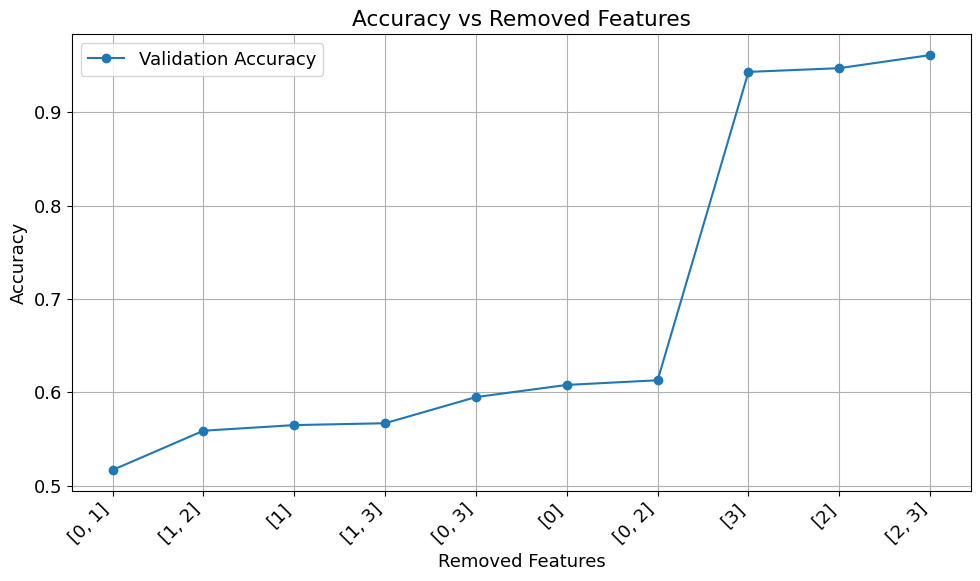

In [63]:
least_important_features_indices = [[0], [1], [2], [3], [0, 1], [1, 2], [2, 3], [0, 2], [0, 3], [1, 3]]
accuracies = []

# Iterate over different sets of least important feature indices
for indices in least_important_features_indices:
    # Exclude the least important feature(s) from the training and testing data
    x_train_reduced = np.delete(x_train, indices, axis=1)
    x_test_reduced = np.delete(x_test, indices, axis=1)

    # Retrain the model using the reduced data with L' features
    reduced_model = XGBClassifier(seed=1, objective='binary:logistic',
                                  learning_rate=0.1,
                                  reg_lambda=0.1, reg_alpha=0.01,
                                  n_estimators=150, max_depth=6, gamma=0)
    reduced_model.fit(x_train_reduced, y_train)
    
    # Predictions on the test set
    y_pred_reduced = reduced_model.predict(x_test_reduced)
    
    # Calculate test accuracy and store it
    accuracy_reduced = accuracy_score(y_test, y_pred_reduced)
    accuracies.append(accuracy_reduced)
    
for i, indices in enumerate(least_important_features_indices):
    print(f"Accuracy after removing features {indices}: {accuracies[i]}")

sorted_indices=sorted(range(len(accuracies)), key=lambda k: accuracies[k])
accuracies=[accuracies[i] for i in sorted_indices]

labels = [str(indices) for indices in least_important_features_indices]
labels=[labels[i] for i in sorted_indices]


# Plot accuracy vs removed features
plt.figure(figsize=(10, 6))
plt.plot(labels, accuracies, marker='o', label='Validation Accuracy')
plt.title('Accuracy vs Removed Features')
plt.xlabel('Removed Features')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


### 3\.  XGBoost vs NN
Compare the validation accuracy of XGBoost with that of a simple feed-forward neural network (NN):
- By varying the number of data samples N’ in the training set (i.e., reducing the fraction N’/N of the data set used for training)
- With cross-validation for all cases.

Is the NN or the XGB performing significantly better at low N’?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D

In [5]:
n_class = 3
N,L = len(x), len(x[0])
input_shape = (L, 1)
def build_model(NF=5,KS=6, NF2=5,KS2=4, lamb=0):
    """
    filter = kernel
    NCONV=index of the CNN architecture
    NF=nr of filters in the 1st layer
    KS=kernel size in the 1st layer
    NF2=nr of filters in the 2nd layer
    KS2=kernel size in the 2nd layer
    lamb=not the animal, but lambda, the regularization parameter
    """
    reg = keras.regularizers.l2(lamb)
    model = Sequential()

    model.add(Conv1D(filters=NF, 
                    kernel_size=KS,
                    kernel_regularizer=reg,
                    activation='relu', 
                    input_shape=input_shape))
    model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
    model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(Flatten())
        
    model.add(Dense(n_class, activation='softmax'))
    return model

model =  build_model(KS=11)

c:\Users\primo\OneDrive\Desktop\physics of data\Lab. of Computational Physics (Mod. B)\Ex3\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


ValueError: Computed output size would be negative. Received `inputs shape=(None, 4, 1)`, `kernel shape=(11, 1, 5)`, `dilation_rate=[1]`.

In [ ]:
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()

Show_history(fit)